In [103]:
import scanpy as sc
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 17})
import warnings
warnings.filterwarnings('ignore')

In [104]:
from utils.filehandling import buildGeneset
from utils.clustering import *
from utils.optimization import *

First we load the dataset that contains the immune cells from `cellseparation.ipynb`

In [105]:
adata = sc.read("datasets/immune_adata.h5ad")

We then load each of the gene sets that relate to B-cells, T-cells and Macrophages from the respective json files from the `Genesets` folder.

In [106]:
with open('Genesets/Immune/BCELLS.json', 'r') as file:
    bcell_gene_set = json.load(file)
    bcell_gene_set = bcell_gene_set['genes']
    
with open('Genesets/Immune/TCELLS.json', 'r') as file:
    tcell_gene_set = json.load(file)
    tcell_gene_set = tcell_gene_set['genes']
    
with open('Genesets/Immune/MPHAGES.json','r') as file:
    mphages_gene_set = json.load(file)
    mphages_gene_set = mphages_gene_set['genes']
    
    
bcell_gene_set_final = set(adata.var_names) & set(bcell_gene_set)
print(f"Genes removed from the gene set: {len(set(bcell_gene_set) - bcell_gene_set_final)} out of {len(bcell_gene_set)}\n")

tcell_gene_set_final = set(adata.var_names) & set(tcell_gene_set)
print(f"Genes removed from the gene set: {len(set(tcell_gene_set) - tcell_gene_set_final)} out of {len(tcell_gene_set)}\n")

mphages_gene_set_final = set(adata.var_names) & set(mphages_gene_set)
print(f"Genes removed from the gene set: {len(set(mphages_gene_set) - mphages_gene_set_final)} out of {len(mphages_gene_set)}\n")

Genes removed from the gene set: 2 out of 34

Genes removed from the gene set: 2 out of 19

Genes removed from the gene set: 1 out of 33



And plot their marker gene expression levels group by the immune cell seperation cluster predictions as identified by NMF in `cellseparation.ipynb`.

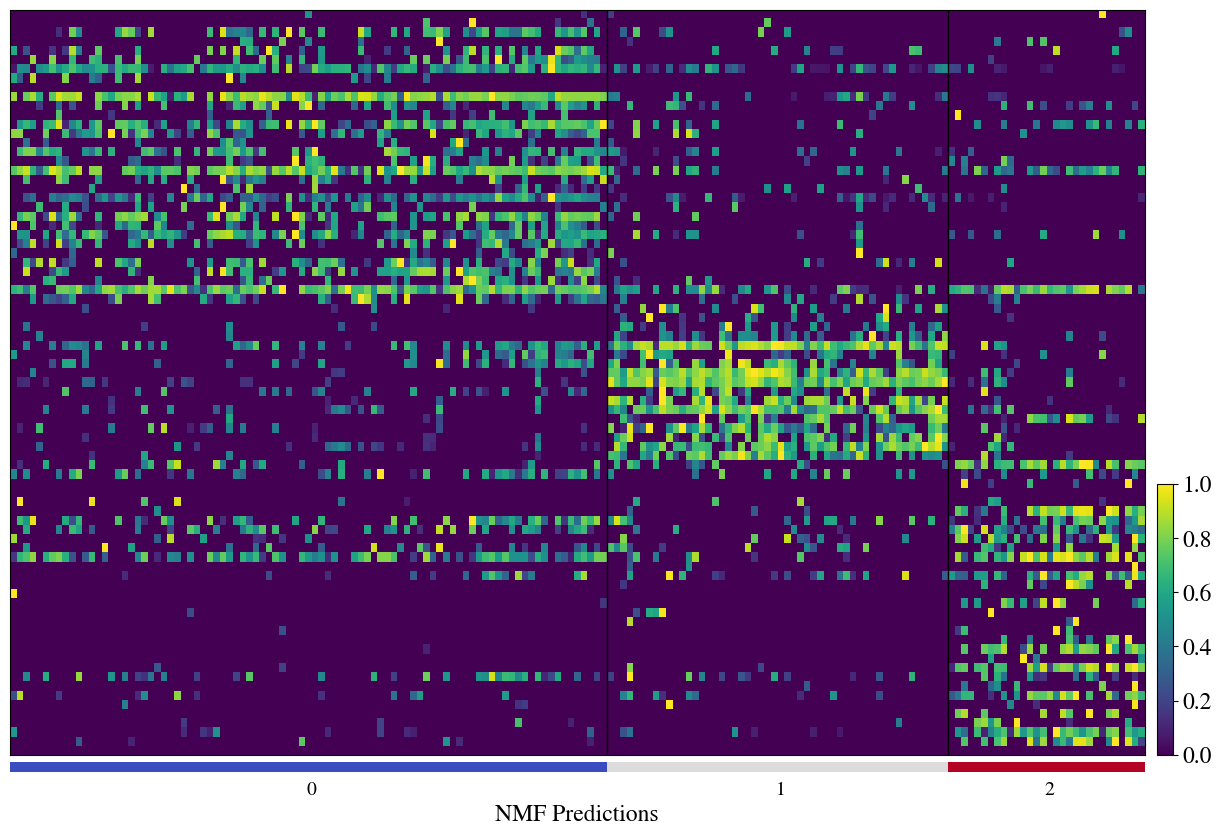

In [107]:
total_genes = list(bcell_gene_set_final) + list(tcell_gene_set_final) + list(mphages_gene_set_final)
marker_adata = adata[:,total_genes]
sc.pl.heatmap(marker_adata, var_names=total_genes , groupby='NMF Predictions', use_raw=False, show=True,swap_axes=True, figsize=(15,10),standard_scale='var')

From the above its evident that the cluster with label 0 expresses the BCELL related geneset, cluster 1 expresses the TCELL related geneset and cluster 2 expresses the Macrophage related geneset. Thus we can name the clusters accordingly.

In [108]:
marker_adata.obs['NMF Predictions']

BC02_60       2
BC03_03       0
BC03_06       0
BC03_24       0
BC03_25       1
             ..
BC09_Re_94    1
BC09_Re_95    1
BC10_07       2
BC10_43       2
BC11_28       1
Name: NMF Predictions, Length: 173, dtype: category
Categories (3, object): ['0', '1', '2']

In [109]:
label_mapping = {'0': "B-CELL", '1': "T-CELL", '2': "MP-CELL"}
marker_adata.obs['NMF Predictions'] = [label_mapping[label] for label in marker_adata.obs['NMF Predictions']]

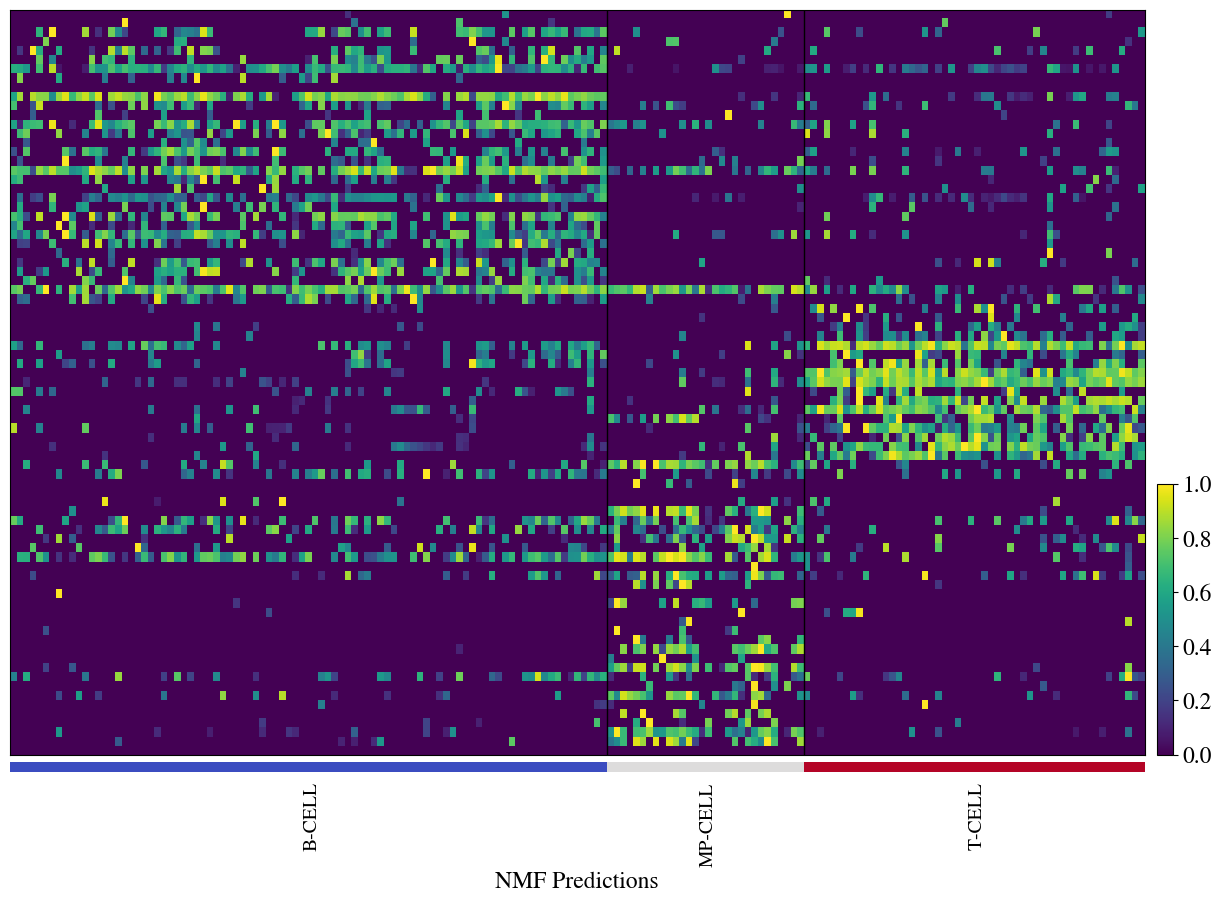

In [110]:
sc.pl.heatmap(marker_adata, var_names=total_genes , groupby='NMF Predictions', use_raw=False, show=True,swap_axes=True, figsize=(15,10),standard_scale='var')

Below we plot the expression levels of the marker genes as above, but now with the tumour groups.

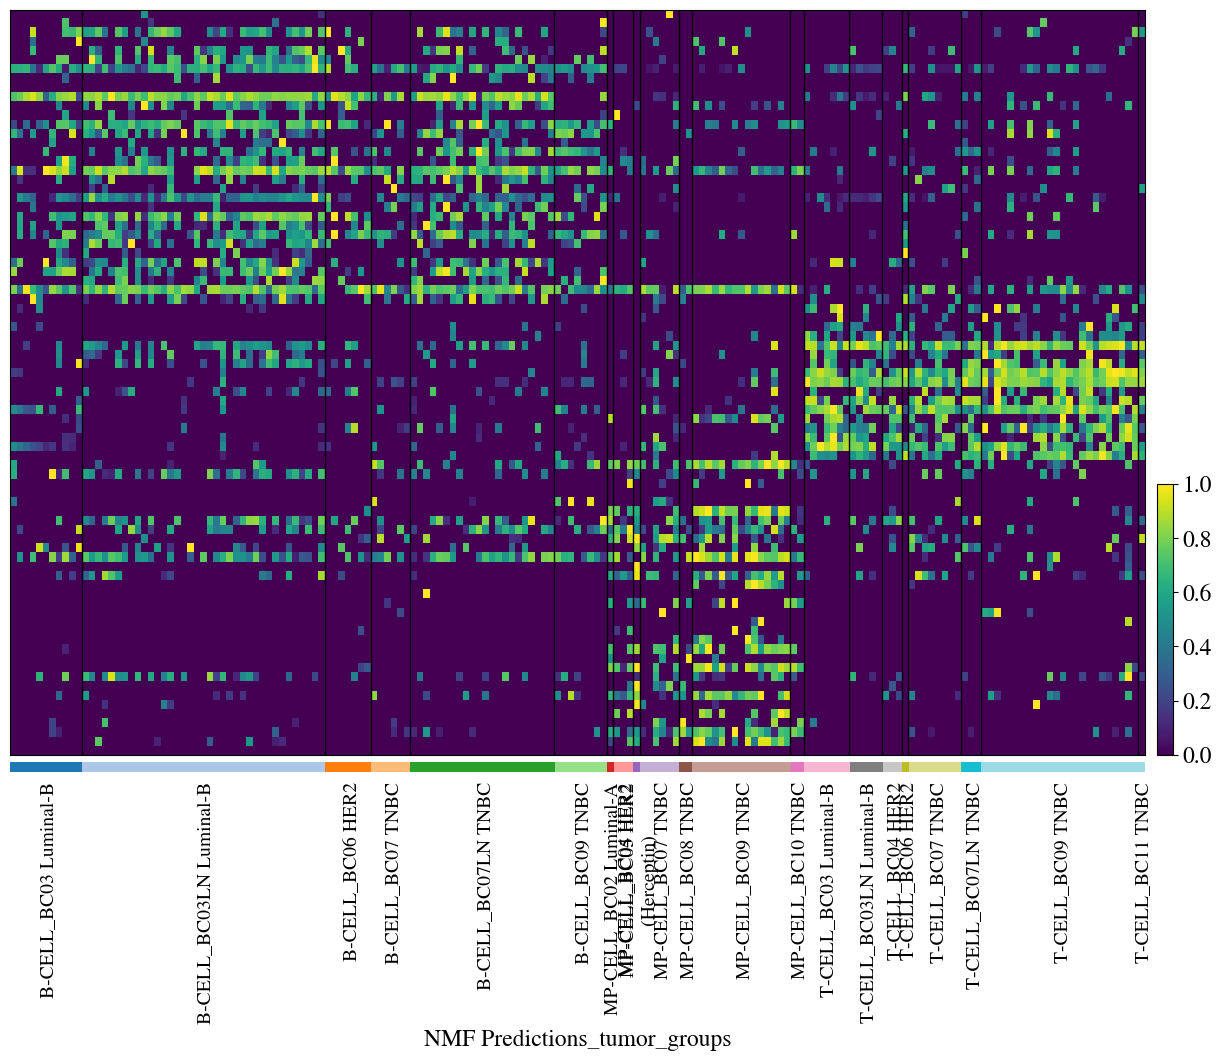

In [111]:
sc.pl.heatmap(marker_adata, var_names=total_genes , groupby=['NMF Predictions','tumor_groups'], use_raw=False, show=True,swap_axes=True, figsize=(15,10),standard_scale='var')

# **T-cell singnature pathway Clustering** 

The next stage consists of the seperation of T-cells into their respective signature pathways via clustering on the expression levels of pathway relevant gene-sets.
First of we seperate the observations the correspond to T-cells from the rest of the dataset. 

In [112]:
adata_tcells = adata[adata.obs['Ground cell type']=='Tcell'].copy()

And load the gene-sets with the usual by now method. 

Below we present the expression levels of the pathway gene-sets before clustering.

Genes removed from the gene set: 0 out of 6

Genes removed from the gene set: 0 out of 7

Genes removed from the gene set: 0 out of 6

Genes removed from the gene set: 0 out of 43

Genes removed from the gene set: 0 out of 55

Genes removed from the gene set: 0 out of 4

Genes removed from the gene set: 0 out of 7



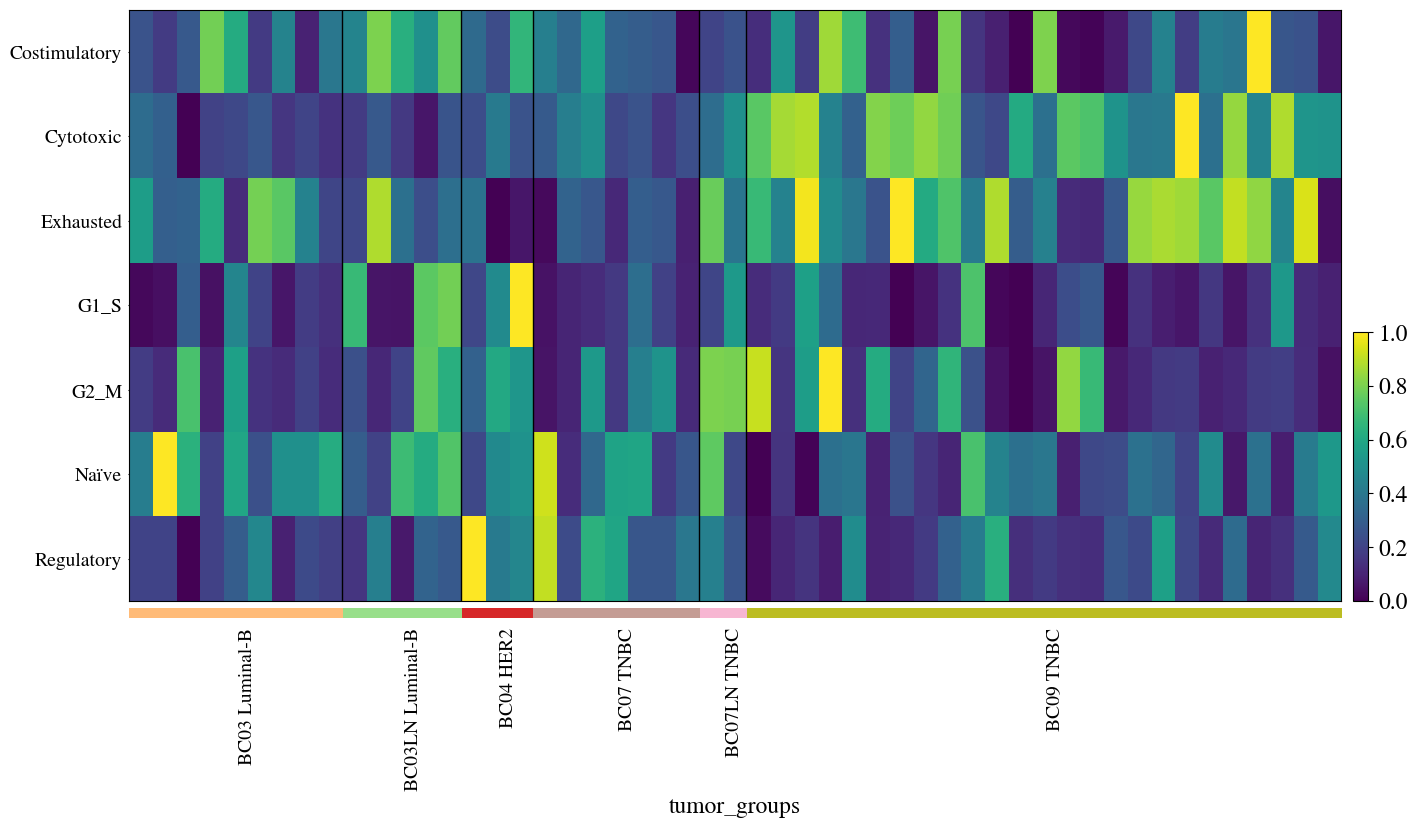

In [113]:
gene_set_list = []
gene_sets = buildGeneset(directory='Genesets/Tcells/',adata=adata_tcells)
for key in gene_sets.keys():
  # For single cell data
  sc.tl.score_genes(adata_tcells,gene_sets[key],score_name = key)
  gene_set_list.extend(gene_sets[key])
  
adata_tcells = adata_tcells[:,gene_set_list]
# Plot scingle cell data
sc.pl.heatmap(
    adata_tcells,
    var_names=list(gene_sets.keys()),
    groupby="tumor_groups",
    swap_axes=True,
    standard_scale='var',
    vmin=0,
    vmax=1,
    figsize=(16, 8)
)

Now we begin clustering:

### **Hierarchical: Average linkage**

In [114]:
data = adata_tcells.X

The silhouete score in the optimal PCA space is: 0.14679360508689565


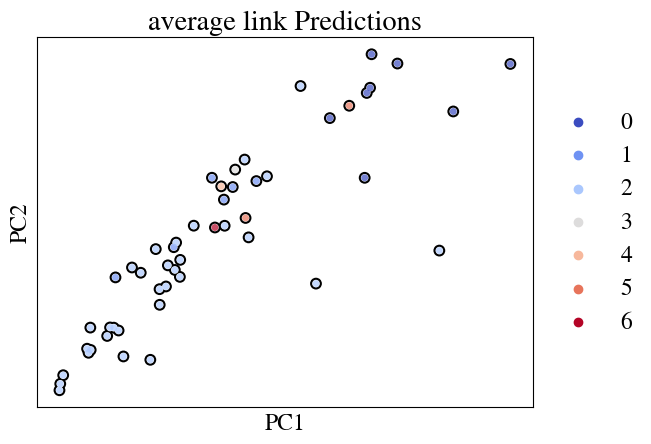

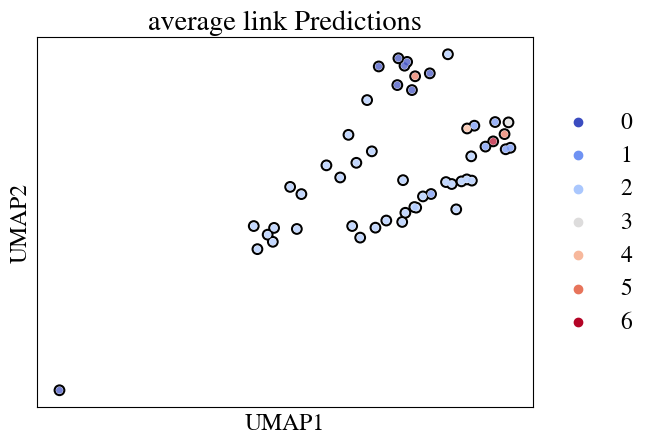

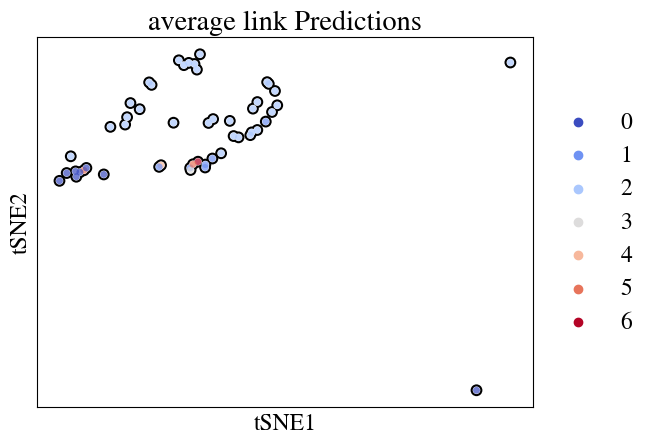

In [115]:
ha_score = hierarchical(data,adata_tcells,'average',n_clusters=7,compare=False)

## **Spectral Clustering**

In [116]:
def Spectral_trial(trial):
  n_neighbors = trial.suggest_int("n_neighbors",2,50)
  spectral = SpectralClustering(n_clusters=7,
                                affinity='nearest_neighbors',
                                n_neighbors=n_neighbors,
                                assign_labels="cluster_qr",
                                random_state=10)
  labels = spectral.fit_predict(data)
  try:
    return silhouette_score(data, labels, random_state=42)
  except ValueError:
  # Return the worst score if it does not converge
    return -1

pruner = optuna.pruners.HyperbandPruner()
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
study.optimize(Spectral_trial, n_trials=100, show_progress_bar=True)

# Get the best parameters and objective value
best_params = study.best_params
best_value = study.best_value
print(best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

{'n_neighbors': 6}


The silhouete score in the optimal PCA space is: 0.05947673995982895


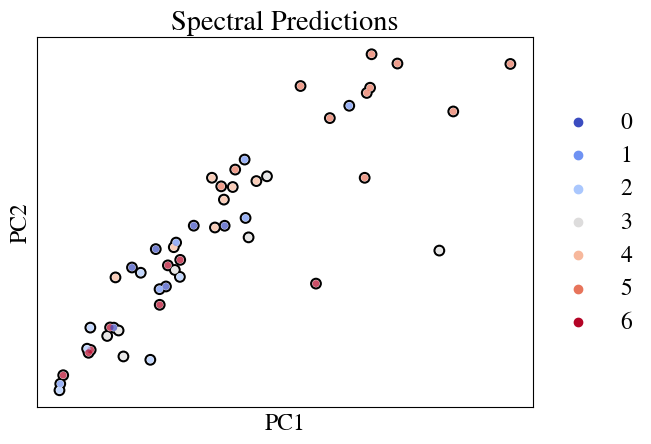

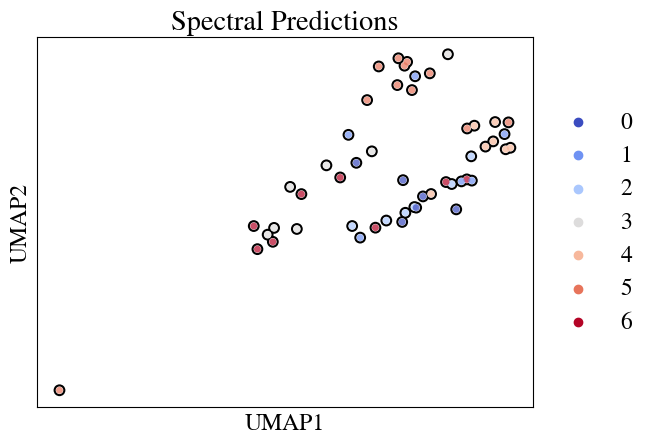

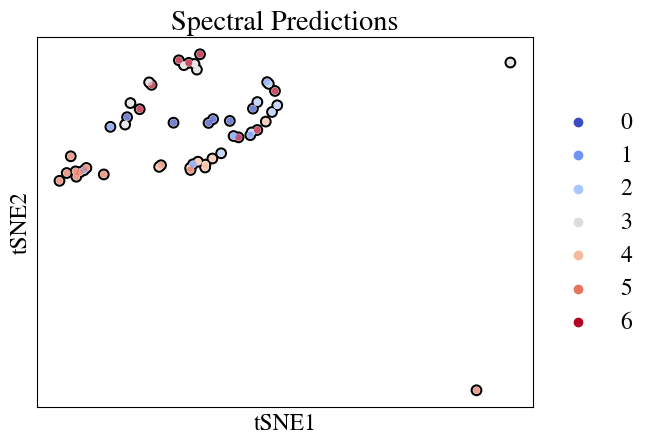

In [117]:
sp_score = spectral(data,adata_tcells,n_neighbors=best_params['n_neighbors'],comparison_key='Ground cell type',n_clusters= 7,compare=False)

### Hierarchical complete linkage

The silhouete score in the optimal PCA space is: 0.09904566435617919


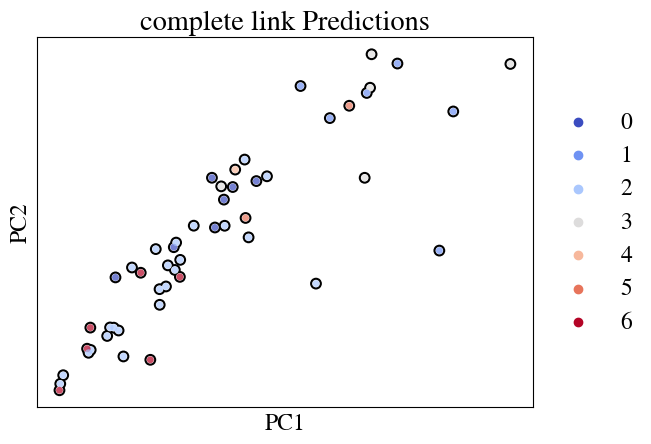

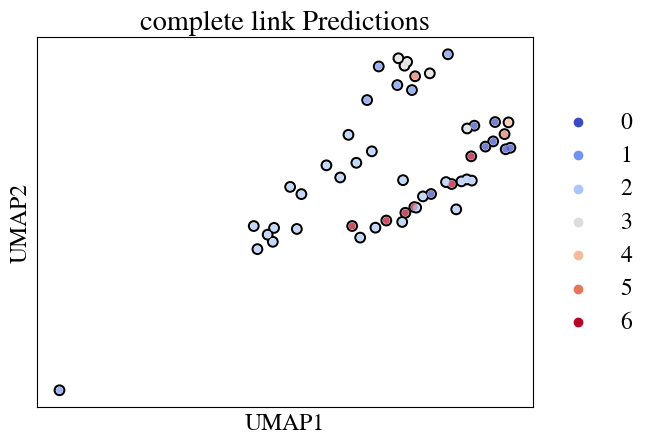

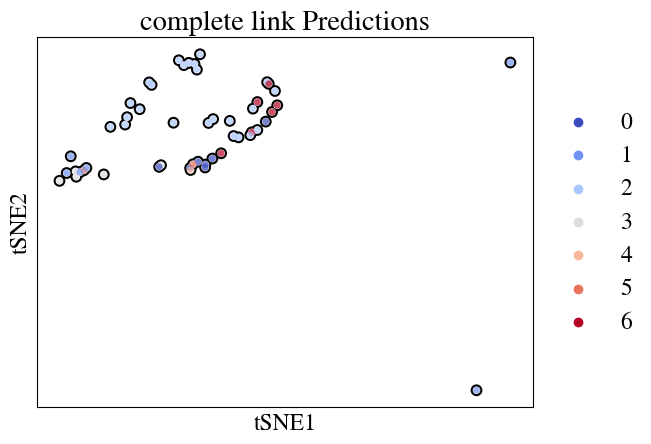

In [118]:
hc_score = hierarchical(data,adata_tcells,'complete',n_clusters=7,compare=False)

The silhouete score in the optimal PCA space is: 0.04184794652008563


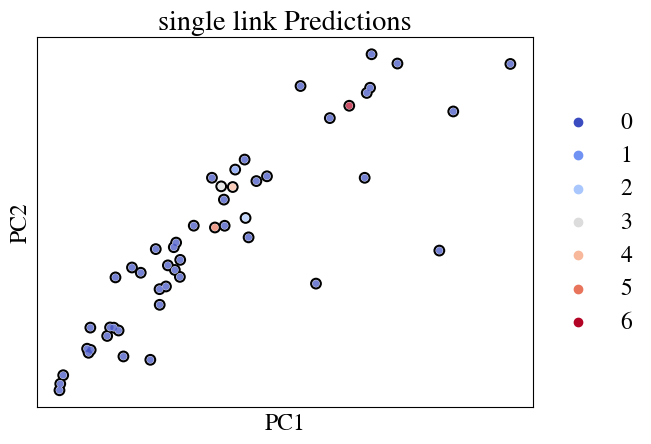

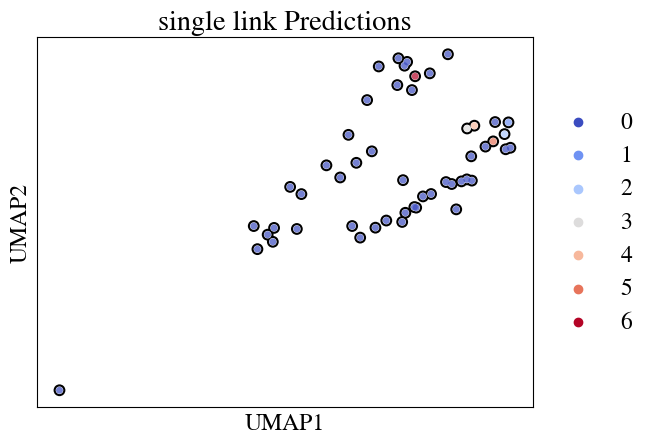

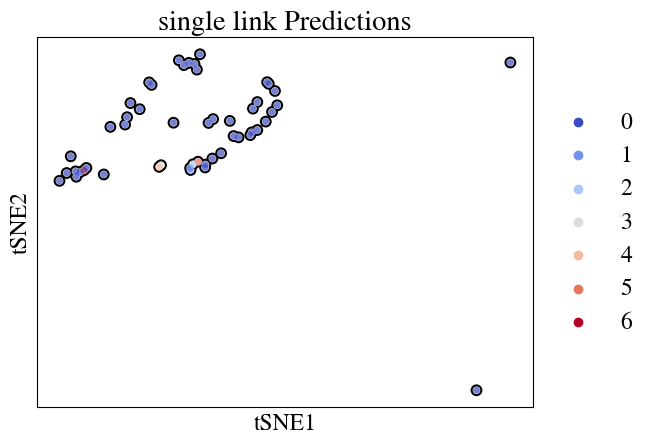

In [119]:
hs_score = hierarchical(data,adata_tcells,'single',n_clusters=7,compare=False)

The silhouete score in the optimal PCA space is: 0.057797832912105


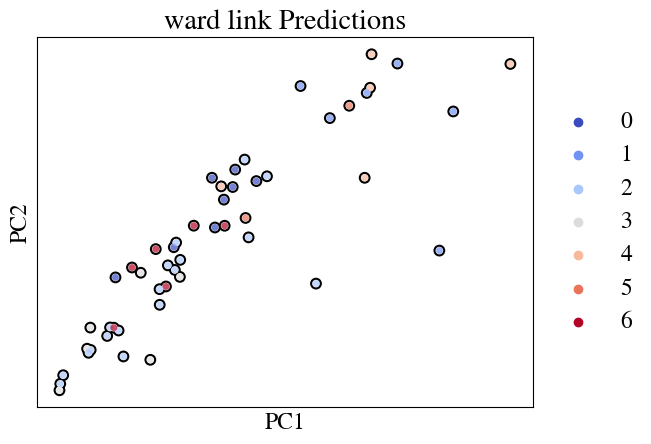

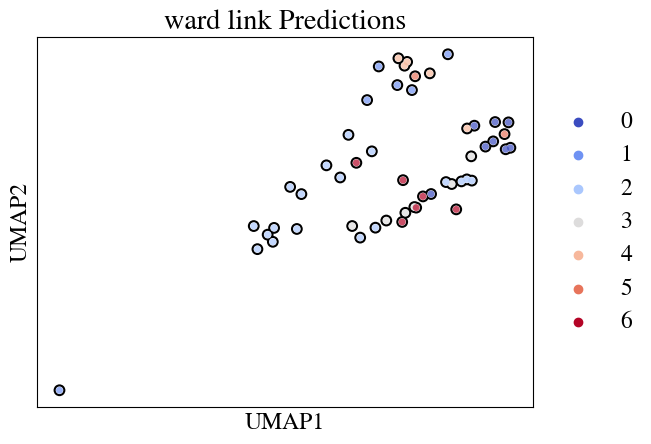

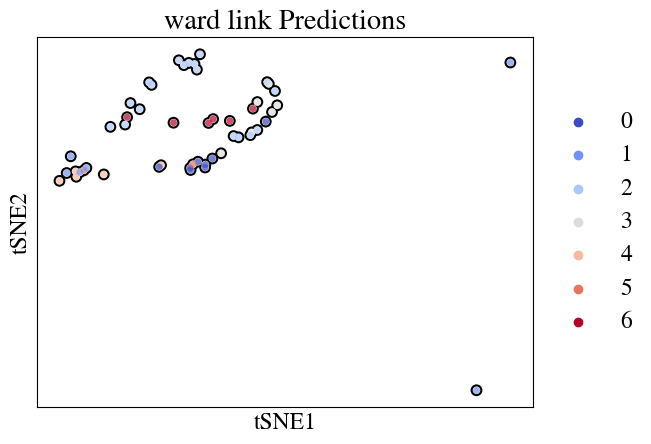

In [120]:
hw_score = hierarchical(data,adata_tcells,'ward',n_clusters=7,compare=False)

# **Results of T-cell signature seperation**

Since no ground labels were available for the T-cell signature seperation, we can only evaluate the results by the shilouete score.

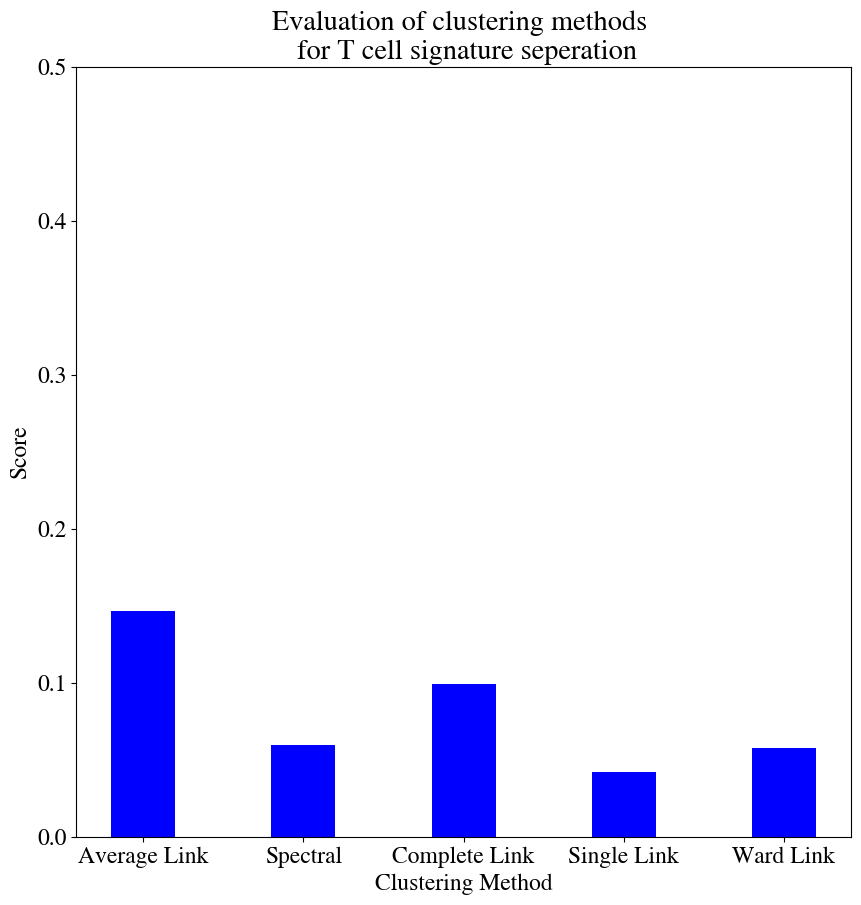

In [121]:
results_df = pd.DataFrame({'Method':['Average Link','Spectral','Complete Link','Single Link','Ward Link'],
                        'Silhouette Score':[ha_score,sp_score, hc_score, hs_score, hw_score]})
                        

plt.figure(figsize=(10,10))
plt.bar(x = results_df['Method'], height = results_df['Silhouette Score'], color = 'blue', width = 0.4)
plt.title("Evaluation of clustering methods \n for T cell signature seperation")
plt.ylabel("Score")
plt.xlabel("Clustering Method")
plt.yticks(np.arange(0.0,0.6,0.1))
plt.show()

# Results heatmap

Finally we present the heatmap of the clustered pathway expression levels grouped by tumour groups.

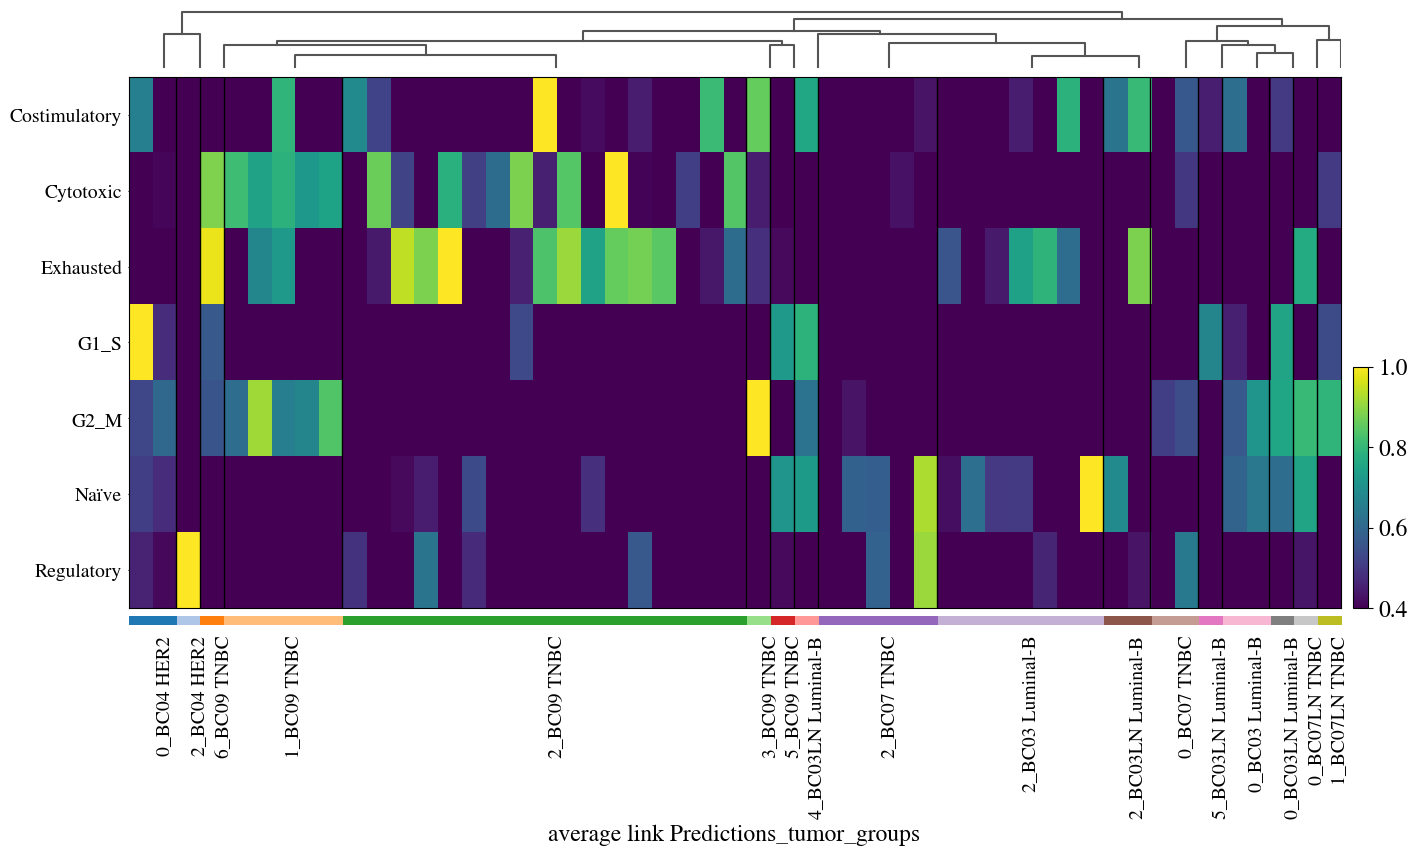

In [123]:
sc.pl.heatmap(
    adata_tcells,
    var_names=list(gene_sets.keys()),
    groupby=[f"average link Predictions","tumor_groups"],
    swap_axes=True,
    standard_scale='var',
    dendrogram=True,
    vmin=0.4,
    vmax=1,
    figsize=(16, 8)
)